In [1]:
import os
import re
import json
from deep_translator import GoogleTranslator
#from deep_translator.exceptions import NotValidPayload

In [2]:
LANGUAGE = 'en'

In [3]:
data_path = '../data/2023-04-12_oasst_ready.trees.jsonl'
with open(data_path, 'r') as f:
    data = [json.loads(line) for line in f]

In [4]:
for tree in data:
    if tree['prompt']['lang'] == LANGUAGE:
        break
tree

{'message_tree_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
 'tree_state': 'ready_for_export',
 'prompt': {'message_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
  'user_id': 'c3fe8c76-fc30-4fa7-b7f8-c492f5967d18',
  'created_date': '2023-02-05T14:23:50.983374+00:00',
  'text': 'Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.',
  'role': 'prompter',
  'lang': 'en',
  'review_count': 3,
  'review_result': True,
  'deleted': False,
  'synthetic': False,
  'emojis': {'+1': 10, '_skip_reply': 1, '_skip_ranking': 4},
  'replies': [{'message_id': 'c8e83833-ecbc-44fe-b6db-735228c25a1c',
    'parent_id': '6ab24d72-0181-4594-a9cd-deaf170242fb',
    'user_id': '2c96e467-66f0-4be7-9693-bda51356a424',
    'created_date': '2023-02-06T13:50:44.657083+00:00',
    'text': '"Monopsony" refers to a market structure where there is only one buyer for a particula

### Translate the data

In [5]:
translator = GoogleTranslator(source=LANGUAGE, target='sl')
#translator = PonsTranslator(source='en', target='sl')
#translator = DeeplTranslator(source='en', target='sl')
#translator = MyMemoryTranslator(source='en', target='sl')

def extract_code_block(text):
    code = re.findall(r'```[a-z]*\n([\s\S]*?)\n```', text, re.MULTILINE)
    return code if len(code) > 0 else []


def separate_text_and_code(text):
    code_blocks = extract_code_block(text)
    for code in code_blocks:
        text = text.replace(code, 'XXX')
    return text, code_blocks


def _translate(text):
    # extract code blocks
    text, code_blocks = separate_text_and_code(text)
    # do not translate numbers
    if text.isdigit():
        translation = text
    else:
        translation = translator.translate(text, from_language=LANGUAGE)
    # place the code blocks back into the translation
    for code in code_blocks:
        translation = translation.replace('XXX123XXX', code, 1)
    return translation


def translate(text):
    if len(text) < 5000: 
        return _translate(text)

    lines = text.split('\n')
    translations = []
    for line in lines:
        translations.append(_translate(line))
    return '\n'.join([t for t in translations if t is not None])

In [6]:
def translate_message(message, translate):
    text = message['text']
    translation = translate(text)
    if translation is None or len(translation) == 0:
        print('Translation failed for:', text)
        message['translation'] = text
        return message
    message['translation'] = translation
    for reply in message['replies']:
        reply = translate_message(reply, translate)
    return message
    

In [7]:
def translate_tree(tree, translate):
    tree['prompt'] = translate_message(tree['prompt'], translate)
    return tree

In [8]:
def translate_dataset(data, translate, translations_path='data/translated'):
    #os.mkdir(translations_path)
    failed_ids = []
    for tree in data:
        if tree['prompt']['lang'] != LANGUAGE:
            continue
        # catch errors at this stage so as not to stop translation of other trees
        tree_path = os.path.join(translations_path, tree['message_tree_id'] + '.json')
        if os.path.exists(tree_path):
            continue
        try:
            translated = translate_tree(tree, translate)
            # save to file
            with open(tree_path, 'w', encoding='utf-8') as f:
                json.dump(translated, f, ensure_ascii=False)
        except Exception as e:
            print(e)
            print('Translation failed for tree: ' + tree['message_tree_id'])
            failed_ids.append(tree['message_tree_id'])
            continue
    return failed_ids

 --> Text length need to be between 0 and 5000 characters
Translation failed for tree: 26278efc-363c-4b54-bf5e-e82b0802d7ce
It hurt.  The lights!  The smells!  The sounds!  It was all so̶ ͞mu͠ch!! Th̕e̢ b̢r̡i͜gh͞t͡ǹe̕s͏s҉ o̸v͜eŕl̡oa̕dͨ̏ͬ̈́̆͗ed̵͂͊̈́̅̈̄̔ ̓ͤ̅́͝ẻvͫ̿͊ͧ͐̋e̍ryͧ ̊̈s̛ͧ͋e͗͂͂̊m͋̂ͩ͛̔b͛͗͋͜l̡͒̂̏a̿ͨͬ͌n͒ͣ̅ͨ͜ċ̍ͥ̃͌ͮ̽eͯ̀ͣͧ͑͊ͣ ̢ͩͤõͨ̐̉͆͗f̀̈ ͪ͞v̒̈́ͪiͤͬͯ̚s̨ͯi̾̏̈̈͋ͣͪo͋͠n̷ͯ͊͑ͫ̎ ͣ̈ͬ̇̄tͦ͌ͦ̅ḩ̀͑ͬͤ͋̂ͮat̵̅ͣ͆ ͭͪẗhͦͬẻ̷͐̊ ̍ͭrͯͭͩͫ̚o̅̊̋ͤ́̋b̴ơͦt̻̗͉̪͢ͅ ̢͕̰̐̄̅̉h̦͌̒̓͒͑a̶̯̘̠͂̅̋͊̌ͥͅḍ̴̜̩̣̭̜͇ͦ̏̓͂ ̶͗͒̎͛́c͙͚̥͎͇̩̱̆̾͒ͤo͇̹̬ͩm̺͉͎͎̮ͤ̂̐̎͋ͤ͋͟e̵̼̲͍̩̪̗̐ͭ ̟̫͉̹̠̜̰͂tͫ̇o̗͎̻̫̬͎͉ͫ̋ͫ̈́̀ ͚̹̙̮̦ͥk̙̟̪ͤ͆̓ͣͧn͇̮̻͕ͯͧ͆̃̈o͎̣̯w̨̻͚̅.̈̋ͤ̑҉͇̩̼͉ ̵̩̱̤͋̏̀ͪ̋ͨ ̶̙̜͎̪̗͑͌̐̇̒̚T̰̥̪͎͔͂̔͛͊͠h̢͇̘̞͚̜̰͖ͭ̽ȇ͒ͫ̓́ ͣ̑ͤsͮm͍͎͚̦̥̳̊͒͠e̡͊̂̀ͪ͂l̘̍͛̑ͣ̇l̫ͮ͑̊̈́̚s͈̯͎̗̖̙̫͌̀ͮͦ̄‒̰̮̞̥͉̾͒ͥͣ̑ ̯̀̋̒̅ͤ͛O͈̗̭̭͙͑ͅh̩ͬ͊̓͜,̱̦̗̟̜ͪ͌̀͋ͭ̎ͅ ̗͚̹͖̠͆t̨̠͍͇͖͈̺̉͆h̪͎̙̓̇̚͠ͅȩ̗̂ ̷͎̤̫̪̙̽̂ͤ̇ͬ̉s̬m̧͈̻̝e̮̹̳̮͈̪̲ͬͬḷ̶͚̰͂̋l̅͋̏̚͏š̺̰̞̫̉̄̊̂͢!̳̙͕̤͕̎̊̓̆̅͌̈ ̮̬̘̝̈́̃ ̯̹͐̿ͮ̀̅̒͒͜A̲̬̿́n͈͓̐ ͙͍͖̗̺͎͎͗͌ͭ̒̍͊ȉ̖̟̪̩͖ͅn̤̫̙͕ò̱̦̻̦̭̳̉͌ͮͤ͡r͇̗͇̔̋ͭ̿̿͊d̼̗̲̖̑͋̈̐̅̆͋ͅi͖̩̠̭̣̼ͭ͜ͅn̜̥̯̩̺̼̲̈́̔͋̈͆͞a̩̻̪̣̱͑ͮ̂ͣͣ͜t͉͔͙ͫ̓̉̓̽ͅĕ̍̋̈́ͥͤ͏̗̲̰̖̘̝͓̞ͪ̌͊ 
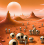

In [9]:
failed_ids = translate_dataset(data, translate, translations_path='../data/google_translate')

In [10]:
failed_ids

['26278efc-363c-4b54-bf5e-e82b0802d7ce',
 '50ad2dbd-dabe-4c00-8116-7bd34923263a',
 '069faa7f-1305-4d63-9a46-442e1d8971b4']

## Check the translated conversation

In [11]:
def generate_conversation(tree):
    conversation = []
    message = tree['prompt']
    conversation.append((message['role'], message['translation']))
    while len(message['replies']) > 0:
        message = message['replies'][0]
        conversation.append((message['role'], message['translation']))
    return conversation

In [12]:
tree_id = tree['message_tree_id']
#tree_id = '2fd4c8cc-b33f-4368-b85a-4284331fd23b'
#tree_id = data[1236]['message_tree_id']

with open('../data/google_translate/' + tree_id + '.json', 'r') as f:
    translated = json.load(f)

In [13]:
conv = generate_conversation(translated)
for role, line in conv:
    print(f'{role.upper()}: {line}')

PROMPTER: Ali lahko napišete kratek uvod o pomembnosti izraza "monopson" v ekonomiji? Uporabite primere v zvezi s potencialnimi monopsoniji na trgu dela in navedite ustrezne raziskave.
ASSISTANT: "Monopson" se nanaša na tržno strukturo, kjer obstaja samo en kupec za določeno blago ali storitev. V ekonomiji je ta izraz še posebej pomemben na trgu dela, kjer ima monopsonski delodajalec pomembno moč nad plačami in delovnimi pogoji svojih zaposlenih. Prisotnost monopsona lahko povzroči nižje plače in zmanjšane zaposlitvene možnosti za delavce, saj je delodajalec malo motiviran za zvišanje plač ali zagotavljanje boljših delovnih pogojev.

Nedavne raziskave so odkrile potencialne monopsonije v panogah, kot sta trgovina na drobno in hitra prehrana, kjer nekaj velikih podjetij nadzoruje pomemben del trga (Bivens & Mishel, 2013). V teh panogah se delavci pogosto srečujejo z nizkimi plačami, omejenimi ugodnostmi in zmanjšano pogajalsko močjo, kar vodi v situacijo, ko so za svoje preživetje odvis

In [14]:
len(os.listdir('../data/google_translate'))

8654

In [21]:
def count_replies(message):
    count = 0
    for reply in message['replies']:
        count += 1 + count_replies(reply)
    return count

messages = 0
for tree in data:
    message = tree['prompt']
    messages += count_replies(message)

messages

78474

In [22]:
characters = 0
items = 0
for tree in data:
    message = tree['prompt']
    characters += len(message['text'])
    items += 1
    for reply in message['replies']:
        characters += len(reply['text'])
        items += 1

characters / items

601.9014587962515

# Save the translated conversation

In [27]:
# combine the trnaslated trees into one file
def combine_translations(translations_path='../data/google_translate'):
    files = os.listdir(translations_path)
    translations = []
    for file in files:
        with open(os.path.join(translations_path, file), 'r') as f:
            translations.append(json.load(f))
    return translations
translations = combine_translations()

In [28]:
with open('../data/google_translate.jsonl', 'w', encoding='utf-8') as f:
    for translation in translations:
        json.dump(translation, f, ensure_ascii=False)
        f.write('\n')